# **Hoja de Trabajo 2**
**Daniela Navas**

## **Task 3** - Preguntas Prácticas

Desarrolle un agente básico capaz de resolver un problema simplificado del Proceso de Decisión de Markov (MDP). Considere utilizar un ejemplo bien conocido como el entorno 'Frozen Lake'. Proporcione el código Python para el proceso de toma de decisiones del agente basándose únicamente en los principios de los procesos de decisión de Markov. Recuerde que para este tipo de problema, el ambiente es una matriz de 4x4, y las acciones, pueden ser moverse hacia arriba, abajo, derecha, izquierda. Considere que el punto inicial siempre estará en la esquina opuesta del punto de meta. Es decir, puede tener hasta 4 configuraciones diferentes. Por ejemplo, el punto inicial puede estar en la coordenada (0, 0) y el punto de meta en la coordenada en la coordenada (3, 3). Además, la posición de los hoyos debe ser determinada aleatoriamente y no debe superar el ser más de 3. Es decir, si aleatoriamente se decide que sean 2 posiciones de hoyo, las coordenadas de estas deben ser determinadas de forma aleatoria. Asegúrese de usar “seed” para que sus resultados sean consistentes.


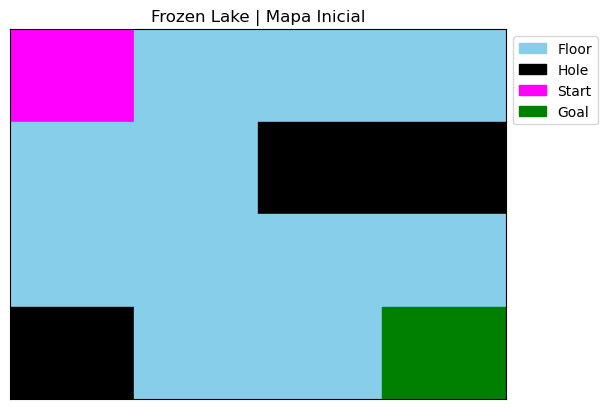

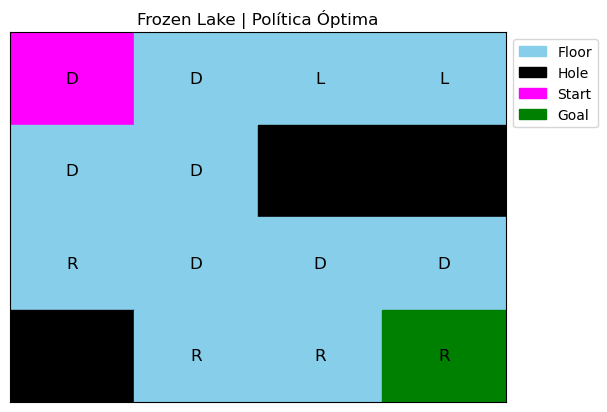

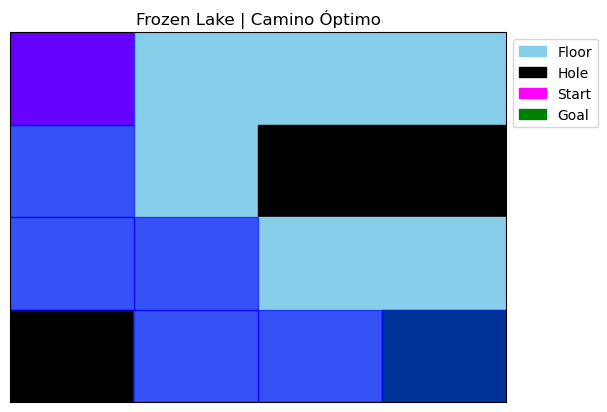

In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt

# *******************************************************************
#
# Definir el Frozen Lake
# 
# *******************************************************************
def frozen_lake(seed, size, num_holes):
    random.seed(seed) # Usar una seed para que sea replicable
    np.random.seed(seed)
    
    # Tablero vacío
    lake = np.full((size, size), 'F')  # F -> Floor | Se puede caminar
    
    # Elegir aleatoriamente la cantidad de hoyos (H)
    num_holes = min(num_holes, size * size - 2)  # Máximo permitido sin bloquear start/goal
    hole_positions = set()
    while len(hole_positions) < num_holes:
        pos = (random.randint(0, size-1), (random.randint(0, size-1)))
        if pos not in [(0, 0), (size-1, size-1)]:
            hole_positions.add(pos)
    
    for hole in hole_positions:
        lake[hole] = 'H'
    
    # Posición inicial y meta | Esquinas opuestas
    start_positions = [(0, 0), (0, size-1), (size-1, 0), (size-1, size-1)]
    start = random.choice(start_positions)
    goal = (size-1, size-1) if start == (0, 0) else (0, 0)
    
    lake[start] = 'S'  # Start
    lake[goal] = 'G'  # Goal
    
    return lake, start, goal

import numpy as np

# ***#****************************************************************
#
# Iteración para política óptima
#
# *******************************************************************
def value_iteration(env, gamma=0.9, theta=1e-4):    
    size = env.shape[0]  # Tamaño de la matriz
    states = [(i, j) for i in range(size) for j in range(size) if env[i, j] != 'H'] # Lista de estados válidos (excluyendo los holes 'H')
    actions = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)} # Definición de las acciones posibles 
    
    # Inicialización de la función de valores con ceros y de la política con la acción 'R' por defecto
    V = np.zeros((size, size))
    policy = {s: 'R' for s in states}
    
    while True:
        delta = 0  # Variable para medir el mayor cambio en los valores de estado en una iteración
        for s in states:
            if env[s] == 'G':  # Si el estado es la meta, no necesita evaluación
                continue
            v = V[s]  # Guardar el valor actual del estado para calcular la diferencia después
            best_action = None  # Mejor acción a elegir
            max_value = float('-inf')  # Valor máximo encontrado entre las acciones posibles
            
            # Evaluar todas las acciones posibles desde el estado actual
            for a, (di, dj) in actions.items():
                next_s = (s[0] + di, s[1] + dj)  # Calcular el estado resultante de la acción
                
                # Verificar si el nuevo estado es válido (dentro de la cuadrícula y no un agujero)
                if 0 <= next_s[0] < size and 0 <= next_s[1] < size and env[next_s] != 'H':
                    reward = 1 if env[next_s] == 'G' else 0  # Recompensa de llegar a la meta, 0 en otros casos
                    value = reward + gamma * V[next_s]  # Evaluación del estado con descuento de recompensa futura
                    
                    # Si encuentra una mejor acción, actualizar
                    if value > max_value:
                        max_value = value
                        best_action = a
            
            # Actualizar la función de valores con el mejor valor encontrado
            V[s] = max_value
            # Almacenar la mejor acción en la política
            policy[s] = best_action
            
            # Calcular la diferencia máxima entre la iteración anterior y la actual
            delta = max(delta, abs(v - V[s]))
        
        # Si el cambio máximo es menor que theta, la política converge
        if delta < theta:
            break
    
    return policy

# *******************************************************************
#
# Camino óptimo
#
# *******************************************************************
def extract_optimal_path(lake, policy, start, goal):
    path = []
    current = start
    
    while current != goal:
        if current not in policy:  # Si no hay acción definida en el estado actual, se detiene
            break
        
        path.append(current)  # Agregar el estado actual al camino
        
        # Acción recomendada por la política
        action = policy[current]
        
        # Diccionario de movimientos correspondientes a las acciones
        move = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}[action]
        
        # Calcular la nueva posición después de realizar la acción
        next_pos = (current[0] + move[0], current[1] + move[1])
        
        # Si la nueva posición es inválida, detenemos el proceso
        if (next_pos == current or 
            next_pos[0] < 0 or next_pos[0] >= lake.shape[0] or 
            next_pos[1] < 0 or next_pos[1] >= lake.shape[1]):
            break
        
        current = next_pos  # Avanzar al siguiente estado
    
    path.append(goal)  # Agregar el estado objetivo al camino final
    return path


# *******************************************************************
#
# Representación Gráfica 
#
# *******************************************************************
def plot_lake(lake, policy=None, path=None, title="Frozen Lake"):
    size = lake.shape[0]
    colors = {'F': 'skyblue', 'H': 'black', 'S': 'magenta', 'G': 'green'} # Colores 
    labels = {'F': 'Floor', 'H': 'Hole', 'S': 'Start', 'G': 'Goal'} # Leyenda
    fig, ax = plt.subplots() # Plotear de acuerdo a los colores
    for i in range(size):
        for j in range(size):
            ax.add_patch(plt.Rectangle((j, size-i-1), 1, 1, color=colors[lake[i, j]]))
            if policy and (i, j) in policy: # Mostrar letras de política óptima (Si es el caso) | R -> Right; L -> Left; U -> Up; -> Down
                ax.text(j + 0.5, size - i - 0.5, policy[(i, j)], ha='center', va='center', fontsize=12)
    
    if path: # Cuando se tenga el camino se plotea de color azul
        for (i, j) in path:
            ax.add_patch(plt.Rectangle((j, size-i-1), 1, 1, color='blue', alpha=0.6))
    
    ax.set_xticks([]) # Acomodar ejes y títulos
    ax.set_yticks([])
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_title(title)
    
    # Leyenda
    legend_patches = [plt.Rectangle((0,0),1,1, color=colors[k], label=labels[k]) for k in colors]
    ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.show()

# Ejecutar | Semilla, tamaño y agujeros máximos
seed = 44
size = 4
holes = 3

lake, start, goal = frozen_lake(seed, size, holes) 
policy = value_iteration(lake)
optimal_path = extract_optimal_path(lake, policy, start, goal)

# Mostrar gráficos
plot_lake(lake, title="Frozen Lake | Mapa Inicial")  # Mapa inicial
plot_lake(lake, policy, title="Frozen Lake | Política Óptima")  # Con política óptima
plot_lake(lake, path=optimal_path, title="Frozen Lake | Camino Óptimo")  # Con camino óptimo

### **Reflexión**
Realicé algunas mejoras para ayudar con la claridad y visualización de los resultados. Se implemento el uso de matplotlib para graficar el entorno en lugar de solo imprimir la matriz. Incluir títulos y una leyenda para facilitar la interpretación de los elementos en la gráfica. Luego se agregó una tercera visualización que muestra el camino óptimo en color azul, lo que permite identificar de manera clara la mejor ruta hacia la meta, por medio de una función que extrae la secuencia de movimientos óptimos según la política obtenida por la iteración de valores. 